# Projet - ITK/VTK - Etude longitudinale de l’évolution d’une tumeur

In [1]:
import numpy as np
import itk
%matplotlib inline
import matplotlib.pyplot as plt
import itkwidgets
from ipywidgets import interact, fixed
from IPython.display import clear_output
print(itk.Version.GetITKVersion())

5.3.0


## Fonctions utilitaires

In [2]:
def visualize_image(image):
    # Convert the input image to a numpy array
    image_array = itk.array_view_from_image(image)

    # Visualize the image using itkwidgets
    viewer = itkwidgets.view(image_array)
    return viewer

In [3]:
# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_image, moving_image):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1, 2, figsize=(10, 8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_image[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1, 2, 2)
    plt.imshow(moving_image[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

In [4]:
def print_5_slices(images, index_slice, dimension) :
    fig, axs = plt.subplots(1, 5, figsize=(18, 8))
    
    if dimension == 1 :
        if index_slice > images.shape[0] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 5 :
            limit += 1
            i += 1
        
        j = 0
        for i in range(index_slice, limit) :
            axs[j].imshow(images[i, :, :], cmap='gray')
            axs[j].axis('off')
            j += 1
    
    elif dimension >= 2 :
        if index_slice > images.shape[1] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 5 :
            limit += 1
            i += 1

        j = 0
        if dimension == 2 :
            for i in range(index_slice, limit) :
                axs[j].imshow(images[:, i, :], cmap='gray')
                axs[j].axis('off')
                j += 1
        else :
            for i in range(index_slice, limit) :
                axs[j].imshow(images[:, :, i], cmap='gray')
                axs[j].axis('off')
                j += 1
                
    plt.subplots_adjust(wspace=0.05)


In [5]:
# get the output image
PixelType = itk.F

images_1 = itk.imread("./Data/case6_gre1.nrrd", PixelType)
images_2 = itk.imread("./Data/case6_gre2.nrrd", PixelType)

print(type(images_1), type(images_2))
images_1.shape, images_2.shape

<class 'itk.itkImagePython.itkImageF3'> <class 'itk.itkImagePython.itkImageF3'>


((176, 256, 256), (176, 256, 256))

In [6]:
visualize_image(images_1)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [7]:
visualize_image(images_2)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

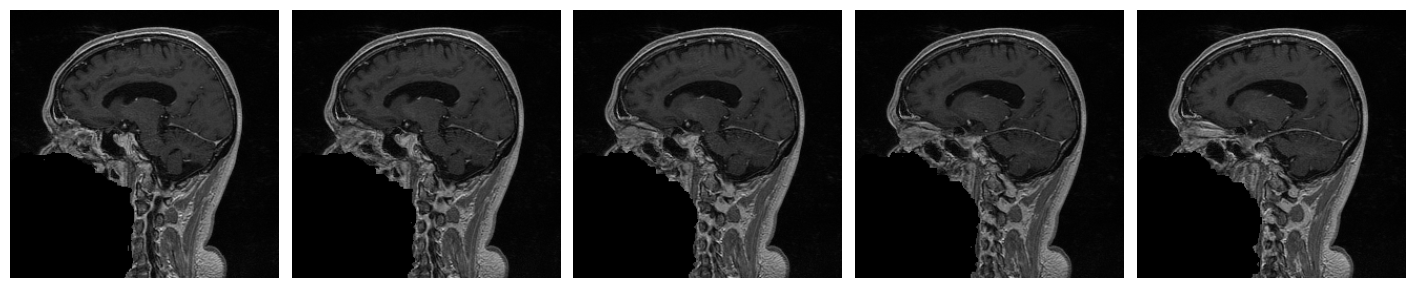

In [8]:
print_5_slices(images_1, 100, 1)

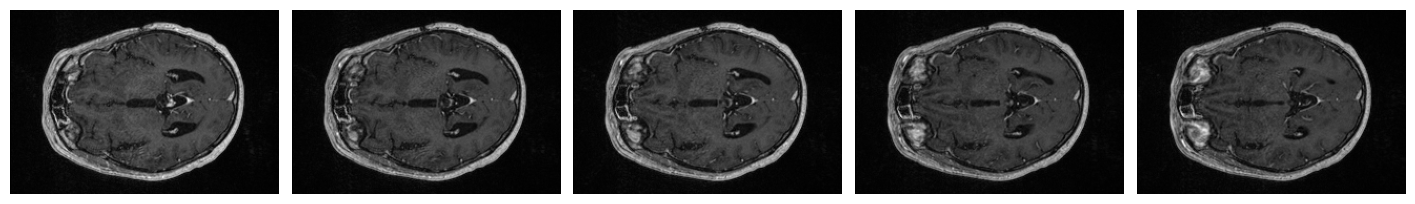

In [9]:
print_5_slices(images_1, 100, 2)

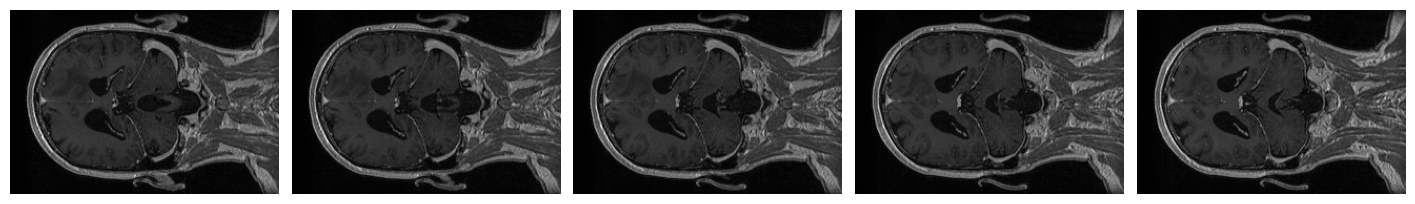

In [10]:
print_5_slices(images_1, 150, 3)

## Etape 1 - Recalage

In [11]:
interact(display_images, fixed_image_z=(1, images_1.shape[0]-1), moving_image_z=(1, images_2.shape[0]-1),
         fixed_image=fixed(images_1), moving_image=fixed(images_2))

interactive(children=(IntSlider(value=88, description='fixed_image_z', max=175, min=1), IntSlider(value=88, de…

<function __main__.display_images(fixed_image_z, moving_image_z, fixed_image, moving_image)>

Voici un widget interactif qui vous permet de visualiser les images fixes et mobiles à différentes coupes dans l'axe y.

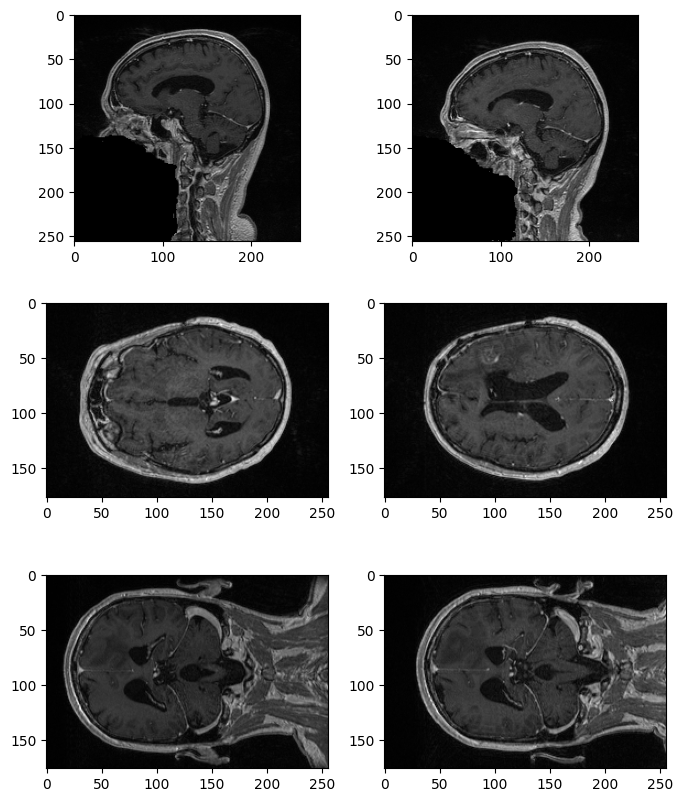

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_1[100, :, :], cmap='gray')
axes[0, 1].imshow(images_2[100, :, :], cmap='gray')
axes[1, 0].imshow(images_1[:, 100, :], cmap='gray')
axes[1, 1].imshow(images_2[:, 100, :], cmap='gray')
axes[2, 0].imshow(images_1[:, :, 150], cmap='gray')
axes[2, 1].imshow(images_2[:, :, 150], cmap='gray')

On peut remarquer qu'il y a une différence marquée d'aligement latéral entre les deux images. Nous effectuerons donc un recalage par translation pour aligner nos images.

In [13]:
dimension = 3
FixedImageType = type(images_1)
MovingImageType = type(images_2)

TransformType = itk.TranslationTransform[itk.D, dimension]
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

optimizer.SetLearningRate(1)
optimizer.SetMinimumStepLength(1e-6)
optimizer.SetNumberOfIterations(100)

metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()
fixed_interpolation = itk.LinearInterpolateImageFunction[FixedImageType, itk.D].New()
metric.SetFixedInterpolator(fixed_interpolation)

registration = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType].New(FixedImage=images_1, MovingImage=images_2, Metric=metric,
                                                                                    Optimizer=optimizer, InitialTransform=initialTransform)

moving_initial_transform = TransformType.New()
initial_parameters = moving_initial_transform.GetParameters()
initial_parameters[0] = 0
initial_parameters[1] = 0
moving_initial_transform.SetParameters(initial_parameters)
registration.SetMovingInitialTransform(moving_initial_transform)

identity_transform = TransformType.New()
identity_transform.SetIdentity()
registration.SetFixedInitialTransform(identity_transform)

registration.SetNumberOfLevels(1)

registration.Update()

transform = registration.GetTransform()
final_parameters = transform.GetParameters()
translation_along_x = final_parameters.GetElement(0)
translation_along_y = final_parameters.GetElement(1)
translation_along_z = final_parameters.GetElement(2)

number_of_iterations = optimizer.GetCurrentIteration()

best_value = optimizer.GetValue()

print("Result = ")
print(" Translation X = " + str(translation_along_x))
print(" Translation Y = " + str(translation_along_y))
print(" Translation Z = " + str(translation_along_z))
print(" Iterations    = " + str(number_of_iterations))
print(" Metric value  = " + str(best_value))

Result = 
 Translation X = -0.7927484241835651
 Translation Y = -3.5743807654084585
 Translation Z = -59.61025848317227
 Iterations    = 89
 Metric value  = 5614.108711314411


In [14]:
resampler = itk.ResampleImageFilter.New(Input=images_2, Transform=transform, UseReferenceImage=True,
                                        ReferenceImage=images_1)
resampler.SetDefaultPixelValue(0)

OutputImageType = itk.Image[PixelType, dimension]
images_2_resampled_casted = itk.CastImageFilter[FixedImageType, OutputImageType].New(resampler)

images_2_resampled = itk.array_from_image(images_2_resampled_casted)

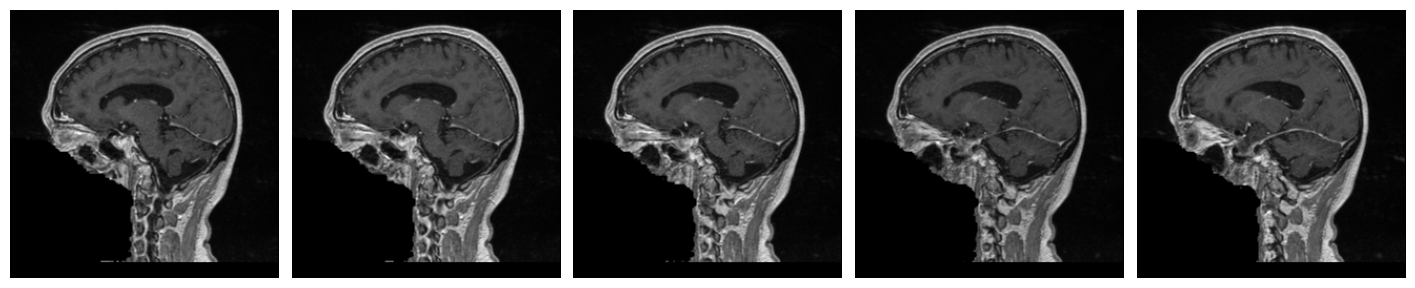

In [15]:
print_5_slices(images_2_resampled, 100, 1)

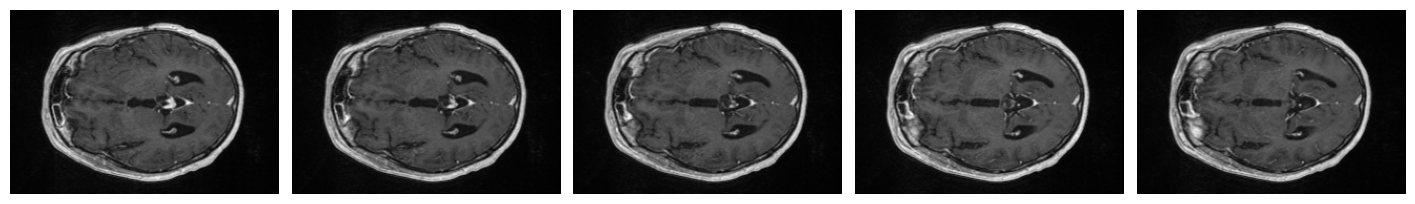

In [16]:
print_5_slices(images_2_resampled, 100, 2)

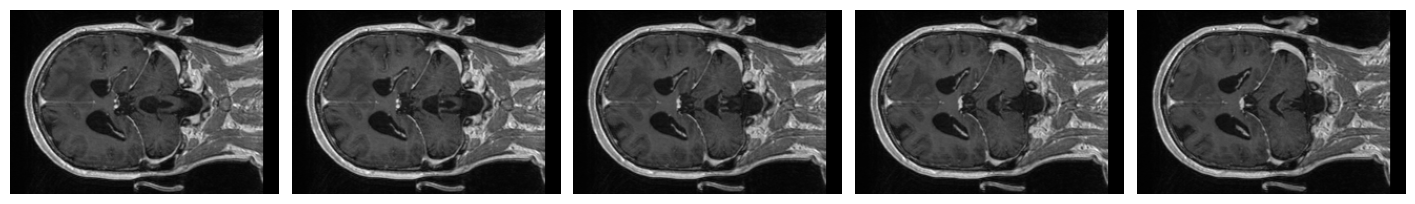

In [17]:
print_5_slices(images_2_resampled, 150, 3)

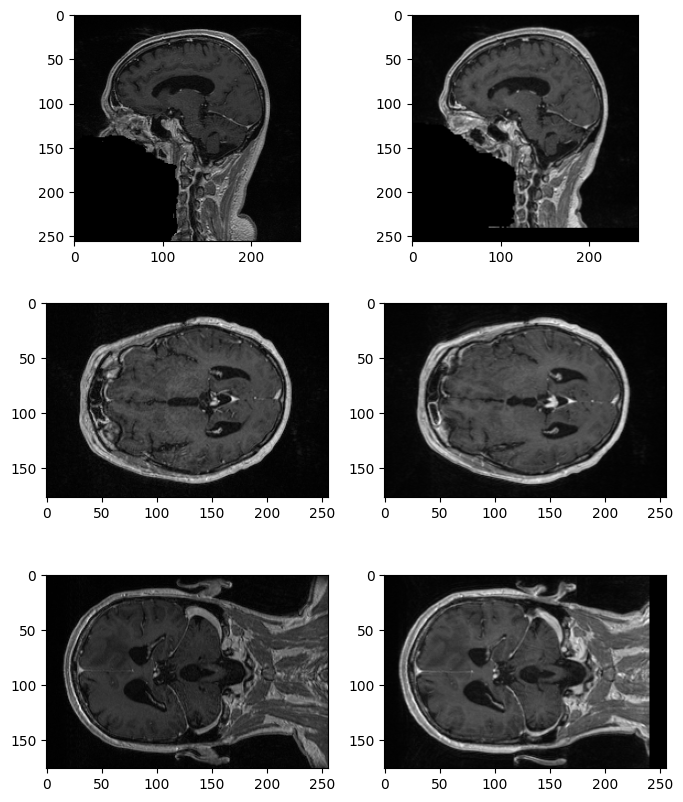

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_1[100, :, :], cmap='gray')
axes[0, 1].imshow(images_2_resampled[100, :, :], cmap='gray')
axes[1, 0].imshow(images_1[:, 100, :], cmap='gray')
axes[1, 1].imshow(images_2_resampled[:, 100, :], cmap='gray')
axes[2, 0].imshow(images_1[:, :, 150], cmap='gray')
axes[2, 1].imshow(images_2_resampled[:, :, 150], cmap='gray')

## Etape 2 - Segmentation

Après analyse visuelle, nous avons remarqué que l'intensité des valeurs de la tumeur variait de 500 à 800 pour l'image 1 et pour l'image 2.

Nous avons ainsi selectionné deux points appartenant à la tumeur pour l'image 1 et pour l'image 2, et avons effectué notre segmentation de tumeur sur chacune des images 3D.

In [19]:
images_2_resampled = images_2_resampled.astype(float)
images_2_resampled = itk.image_from_array(images_2_resampled)

In [20]:
# Cast the images in the same type
cast_filter = itk.CastImageFilter[images_2_resampled, itk.Image[itk.F, 3]].New()
cast_filter.SetInput(images_2_resampled)
cast_filter.Update()

images_2_resampled = cast_filter.GetOutput()

In [21]:
# Smooth the images before segmenting them
smoothing = itk.CurvatureFlowImageFilter.New(Input=images_1)
smoothing.SetNumberOfIterations(5)
smoothing.SetTimeStep(0.125)
smoothing.Update()

images_1_smoothed = smoothing.GetOutput()

smoothing = itk.CurvatureFlowImageFilter.New(Input=images_2_resampled)
smoothing.SetNumberOfIterations(5)
smoothing.SetTimeStep(0.125)
smoothing.Update()

images_2_smoothed = smoothing.GetOutput()

images_1_smoothed.shape, images_2_smoothed.shape

((176, 256, 256), (176, 256, 256))

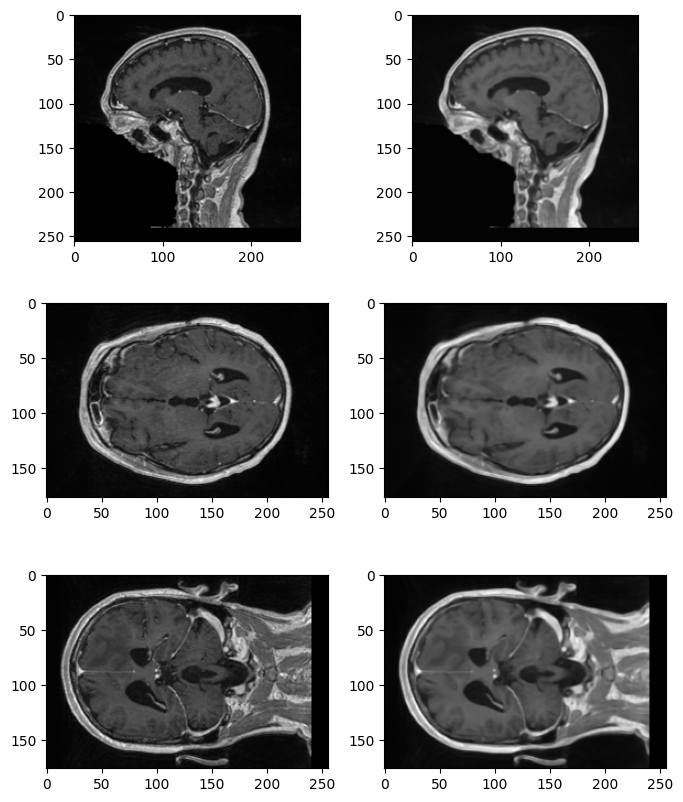

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_2_resampled[100, :, :], cmap='gray')
axes[0, 1].imshow(images_2_smoothed[100, :, :], cmap='gray')
axes[1, 0].imshow(images_2_resampled[:, 100, :], cmap='gray')
axes[1, 1].imshow(images_2_smoothed[:, 100, :], cmap='gray')
axes[2, 0].imshow(images_2_resampled[:, :, 150], cmap='gray')
axes[2, 1].imshow(images_2_smoothed[:, :, 150], cmap='gray')

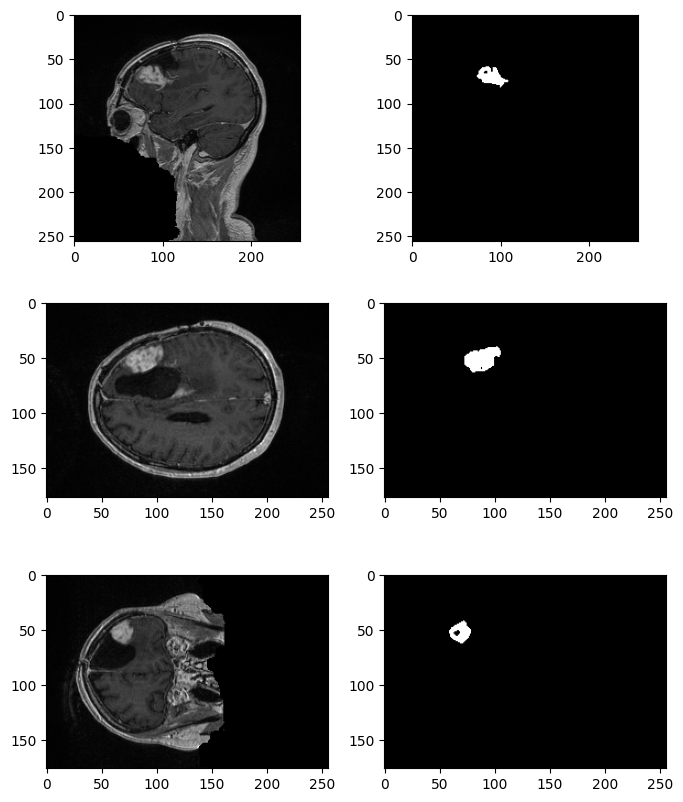

In [23]:
# Perform segmentation on images_1_smoothed
ConnectedFilterType = itk.ConnectedThresholdImageFilter[itk.Image[itk.F,3], itk.Image[itk.F,3]]
connectedThreshold = ConnectedFilterType.New()

lower_threshold = 500.
upper_threshold = 800.
index = (90,70,51)

connectedThreshold.SetInput(images_1_smoothed)
connectedThreshold.SetLower(lower_threshold)
connectedThreshold.SetUpper(upper_threshold)
connectedThreshold.SetReplaceValue(255)


connectedThreshold.SetSeed(index)
seed_value = images_1_smoothed.GetPixel(index)

connectedThreshold.Update()

images_1_segmented = connectedThreshold.GetOutput()

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_1[index[0] - 35, :, :], cmap='gray')
axes[0, 1].imshow(images_1_segmented[index[0] - 35, :, :], cmap='gray')
axes[1, 0].imshow(images_1[:, index[1], :], cmap='gray')
axes[1, 1].imshow(images_1_segmented[:, index[1], :], cmap='gray')
axes[2, 0].imshow(images_1[:, :, index[2] + 30], cmap='gray')
axes[2, 1].imshow(images_1_segmented[:, :, index[2] + 30], cmap='gray')

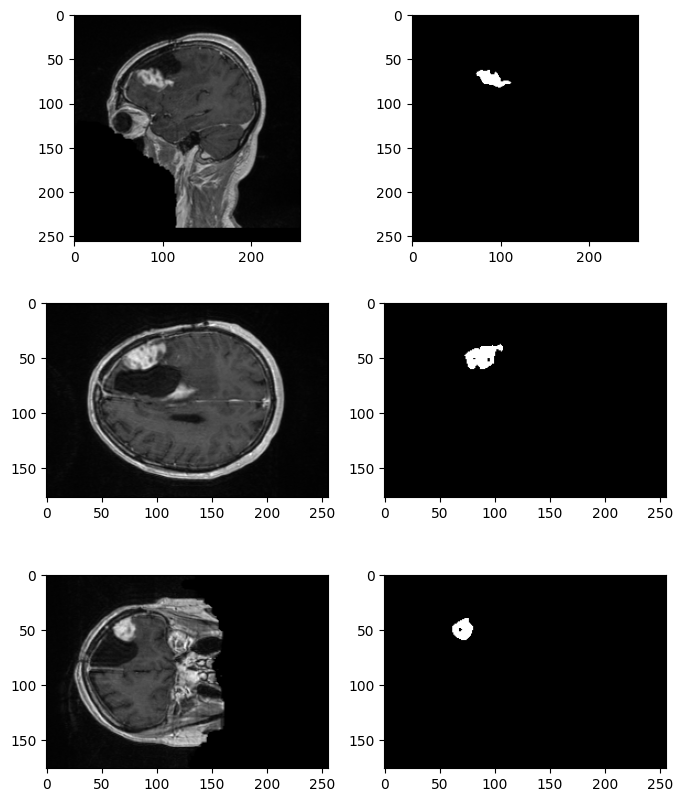

In [24]:
# Perform segmentation on images_2_smoothed
ConnectedFilterType = itk.ConnectedThresholdImageFilter[itk.Image[itk.F,3], itk.Image[itk.F,3]]
connectedThreshold = ConnectedFilterType.New()

lower_threshold = 500.
upper_threshold = 800.
index = (90,70,51)

connectedThreshold.SetInput(images_2_smoothed)
connectedThreshold.SetLower(lower_threshold)
connectedThreshold.SetUpper(upper_threshold)
connectedThreshold.SetReplaceValue(255)

connectedThreshold.SetSeed(index)
seed_value = images_2_smoothed.GetPixel(index)

connectedThreshold.Update()

images_2_segmented = connectedThreshold.GetOutput()

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_2_resampled[index[0] - 35, :, :], cmap='gray')
axes[0, 1].imshow(images_2_segmented[index[0] - 35, :, :], cmap='gray')
axes[1, 0].imshow(images_2_resampled[:, index[1], :], cmap='gray')
axes[1, 1].imshow(images_2_segmented[:, index[1], :], cmap='gray')
axes[2, 0].imshow(images_2_resampled[:, :, index[2] + 30], cmap='gray')
axes[2, 1].imshow(images_2_segmented[:, :, index[2] + 30], cmap='gray')

In [25]:
from ipywidgets import widgets, interactive
from IPython.display import display

slider = widgets.IntSlider(min=1, max=images_1.shape[0]-1, continuous_update=True)

def update_images(image_z):
    display_images(image_z, image_z, images_1_segmented, images_2_segmented)

interactive_plot = interactive(update_images, image_z=slider)
display(interactive_plot)

interactive(children=(IntSlider(value=1, description='image_z', max=175, min=1), Output()), _dom_classes=('wid…

In [26]:
visualize_image(images_1_segmented)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [27]:
visualize_image(images_2_segmented)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

## Etape 3 - Comparaison des différences

In [28]:
def calculate_correlation(segmented_image_1, segmented_image_2) :
    flatten_segmented_image_1 = itk.array_from_image(segmented_image_1).flatten()
    flatten_segmented_image_2 = itk.array_from_image(segmented_image_2).flatten()

    correlation = np.corrcoef(flatten_segmented_image_1, flatten_segmented_image_2)[0, 1]
    
    return correlation

correlation_coeff = calculate_correlation(images_1_segmented, images_2_segmented)

print("Correlation coefficient between the segmented parts of image 1 and 2:", correlation_coeff)

Correlation coefficient between the segmented parts of image 1 and 2: 0.720367693859541


In [29]:
def calculate_volume(segmented_image, voxel_spacing):
    voxel_volume = np.prod(voxel_spacing)
    segmented_voxels = np.count_nonzero(segmented_image)
    volume = segmented_voxels * voxel_volume
    return volume

spacing = images_1.GetSpacing()


print("Voxel spacing:", spacing)
# Assuming segmented_image_1 and segmented_image_2 are your segmented image arrays
# and voxel_spacing_1 and voxel_spacing_2 are the voxel spacing arrays for each image

volume_1 = calculate_volume(images_1_segmented, spacing)
volume_2 = calculate_volume(images_2_segmented, spacing)

print("Volume of segmented image 1:", volume_1)
print("Volume of segmented image 2:", volume_2)

Voxel spacing: itkVectorD3 ([1, 1, 1])
Volume of segmented image 1: 8026.0
Volume of segmented image 2: 8524.0


In [30]:
def calculate_mean_intensity(segmented_image):
    nonzero_voxels = segmented_image[segmented_image != 0]
    mean_intensity = np.mean(nonzero_voxels)
    return mean_intensity

mean_intensity_1 = calculate_mean_intensity(images_1_segmented)
mean_intensity_2 = calculate_mean_intensity(images_2_segmented)

print("Mean intensity of segmented image 1:", mean_intensity_1)
print("Mean intensity of segmented image 2:", mean_intensity_2)

Mean intensity of segmented image 1: 0.17743804
Mean intensity of segmented image 2: 0.18844777


Nous pouvons observer que le coefficient de corrélation entre les deux ségmentations de tumeur provenant des deux images est haut et positif, à 0.72. Cela suggère que les deux ségmentations sont hautement similaires et que les changements sont limités, mais subsistent néanmoins étant donné que la relation n'est pas parfaite.

La deuxième image de la tumeur présente un volume et une intensité moyenne plus importants que la première image. Cela suggère que la deuxième tumeur est en effet différente de la première, plus étendue, et contient une plus grande quantité de tissu tumoral que la première tumeur. 

Le volume représente la taille globale de la tumeur, tandis que l'intensité moyenne reflète la concentration ou la densité des voxels dans la tumeur. Une plus grande intensité moyenne peut indiquer une plus grande accumulation de substances d'intérêt, telles que des marqueurs tumoraux, ou une plus grande densité cellulaire.